![title](../Documents/images/Banner.png)

# Table of Content


**[1. Data Preprocessing](#1)**<br>
**[2. Baseline Models Evaluation](#3)**<br>
**[3. Hypertuning Model](#4)**<br>
**[4. Final Model](#5)**<br>

# Approach One: Classifying Dementia 

Relatively little is known about what causes Dementia in older age, as no one test can determine the diagnosis of Dementia in a patient.  Doctors diagnose Alzheimer's and other types of Dementia based on a combination of factors. Lab tests and other health factors are typically measured to eliminate all other possibilities. A diagnosis for Dementia includes careful examination of medical history, a physical examination, laboratory tests, and the characteristic changes in thinking, day-to-day function, and behavior associated with each type.  Through this type of analysis, doctors can determine that a person has Dementia with a high level of certainty. However, determining if a person will have Dementia is left with much uncertainty as there is no solution to testing and screening for the onset of Dementia before any symptoms.

The focus on this project is on prediction classification for dementia diagnosis using electronic health records of ICU patients from the MIMIC III database. The ultimate goal is to understand the role of the various features in the model's ability to differentiate patients diagnosed with Dementia vs. those who do not have Dementia. 

As found in Exploratory Data Analysis and in many medical and health datasets I am working with very imbalanced dataset. One approach to counteract this imbalanced data problem is to randomly undersample the majoirty class to be balanced to the amount of data in minority class. 

This notebook explores this solution approach by taking the random undersampling of the majoity class to predict dementia diagnosis in patients directly from the whole dataset.

In Part 3 I explore the alternative approach to this by brodening the classifcation modeling in to two fold solution. The first fold explores the classification prediction of patients within the broader ccs diagnosis category, Mental Health. The second fold then assumes given the patient is within the ccs-group of Mental Health can the classifier distinguish patients diagnosed with Dementia from the Mental Health patients.

### Modeling
In this notebook includes several classification models are tested via statical modeling, such as Decision Tree, Random Forest classification, Extra Trees Classification, and XG Boost. These models were selected for their ability to perform well on classification problems. The pros and cons of these models are addressed within each model section.

### Model Evaluation:
The solution approach in this notebook is negating the overall class imbalance by resampling so for evaluating model performance I will use accuracy for baseline model performance and confusion matrix and the percision, recall area under the receiver operating characteristics curve (PR-AUC score) to be able to compare to Part 3 models where class imbalnce will be more problamatic. 

# Imports

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn.impute import MissingIndicator

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.datasets import make_classification 
from imblearn.under_sampling import TomekLinks 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import TomekLinks 
from xgboost import XGBRegressor, XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import auc, average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

# Reading in Data

In [80]:
data = pd.read_csv('../Datasets/mimiciii_aggregated_cleaned.csv')

In [81]:
#creating a filter of non-demented diagnosied patients
no_dementia = data[data['DEMENTIA'] == 0]

In [82]:
#created df of only dementia patients
df_dementia = data[data['DEMENTIA'] == 1]

In [83]:
#generating a df of a 1,000 random rows from the dataframe created 
#containg all patient NOT diagnosed with Dementia.

no_dementia = no_dementia.sample(n = 850, random_state=7)

In [84]:
#concatingting the rows
df = pd.concat([no_dementia, df_dementia], ignore_index=True)

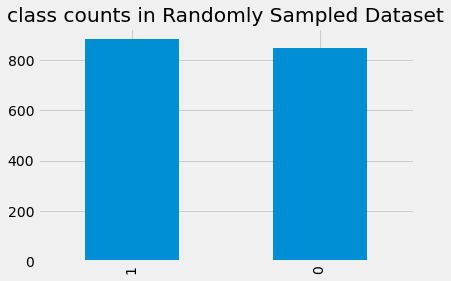

In [85]:
df['DEMENTIA'].value_counts().plot(kind='bar');
plt.title('class counts in Randomly Sampled Dataset');

Above is a visualization of the new dataframe with more balanced clasess. The class labeled 1 are patients with Dementia and the class labeled 0 are those without Dementia. Both class have around 850 counts for a more even split.

<a name="1"></a>
# Defining X and y variables

In [86]:
features = df.drop(columns=['subject_id','MENTAL ILLNESS', 'DEMENTIA'])
X = features
y = df['DEMENTIA']

# Train Test Split

In [87]:
#creating train test split 
#test size = 30% of dateframe
#setting Random State to 9
#stratify set to yes for equal porportions of the y variable in both train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                               random_state=9, stratify=y)

# Null Model

In [88]:
print('\ny_train Class Distribution: \n', y_train.value_counts(normalize=True))


y_train Class Distribution: 
 1    0.509481
0    0.490519
Name: DEMENTIA, dtype: float64


**Interpretation:** The null model here will act as a baseline for estimating model improvement. If the classifyer model always guesses 0 it will have an accuracy of 0.50 and if it always guess 1 the accuracy will be 0.49%. The goal is to train a model that performs better than this null model. 

# Model Preprocessing

### Model Evaluation Function
Below is a function for model evaluation to return both a confusion matrix and classification metrics.

In [89]:
def evaluation(mdl, X_train, y_train, X_test, y_test):
    results = {}
    train_aucc = mdl.score(X_train, y_train)
    test_aucc = mdl.score(X_test, y_test)
    y_pred_train = mdl.predict(X_train)
    y_pred_test = mdl.predict(X_test)
    
    print(f'Training auccuracy: {train_aucc}')
    print(f'Test auccuracy: {test_aucc}')
    print()
    
    tn, fp, fn, tp = confusion_matrix(y_test, mdl.predict(X_test)).ravel() 
    plot_confusion_matrix(mdl, X_test, y_test, cmap='Blues', values_format='d');
    
    print('Order of classes: ', mdl.classes_)
    confusion_df = pd.DataFrame(
                    data=confusion_matrix(y_test, y_pred_test),
                    index=[f'actual {target_class}' for target_class in mdl.classes_],
                    columns=[f'predicted {target_class}' for target_class in mdl.classes_])
    print('\nTest Confusion Matrix: \n', confusion_df)
    
    print()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)  
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    #print('\nTest Confusion Matrix: \n', confusion_df)
    print(classification_report(y_test, y_pred_test))
    # 5. Test recall and precision (if no samples, set recall/precision to 0)
    results['test_recall'] = recall_score(y_test, y_pred_test, 
                                          pos_label=1, zero_division=0)
    results['test_precision'] = precision_score(y_test, y_pred_test,
                                                pos_label=1, zero_division=0)

### Missing Values Imputation

The fist step in model preprocessing is missing values imputation for the X test and train. In the Exploratory Analysis of three different imputation techniques the variabily between the decriptive statistics and theh skewness was not largly impacted by any particular one, but the KNN imputer had the most similar skewness in term of distribution to the original dataset and descriptive statistics on the columns with most missing values. Below the X_train and X_test are being transformed with this KNN Imputer.

In [90]:
knn_imputer = KNNImputer(n_neighbors=2)
X_train = knn_imputer.fit_transform(X_train)
X_test = knn_imputer.fit_transform(X_test)

### Scalling

Since the ranges of max and min for the Lab result vary by test and do not contain the same type of measurement for each test the best option to nuetralize this in modeling is two instantiate and transform the X_test and X_train with a standardscaler from SK.Learn libary. 

In [91]:
# Instantiate our StandardScaler.
ss = StandardScaler()

# Standardize X_train.
X_train = ss.fit_transform(X_train)

# Standardize X_test.
X_test = ss.transform(X_test)

<a name="3"></a>
# Model Selection

### Random Forest Baseline

0.8460919378891966
Random Forest train accuracy: 1.0
Random Forest Test accuracy: 0.8173076923076923


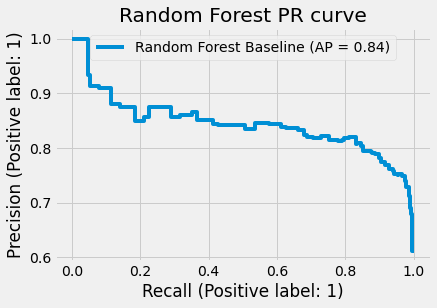

In [94]:
rf_baseline = RandomForestClassifier(n_estimators=100)
rf_baseline.fit(X_train, y_train)


rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_baseline.predict_proba(X_test)[:,1])

print(auc(rf_recall, rf_precision))
train_auc = rf_baseline.score(X_train, y_train)
test_auc = rf_baseline.score(X_test, y_test)

print(f'Random Forest train accuracy: {train_auc}')
print(f'Random Forest Test accuracy: {test_auc}')   

plot_precision_recall_curve(rf_baseline, X_test, y_test, name = 'Random Forest Baseline')
plt.legend(loc="upper center");
plt.title('Random Forest PR curve');

### Decision Tree Baseline

Decision Tree train accuracy: 1.0
Decision Tree Test accuracy: 0.7538461538461538
0.8199554690592427


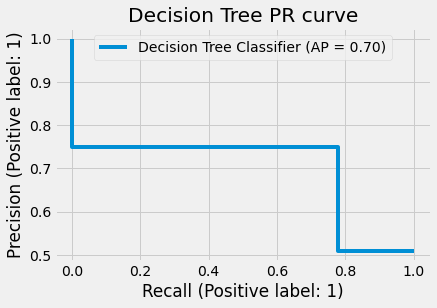

In [95]:
dt_baseline = DecisionTreeClassifier()
dt_baseline.fit(X_train, y_train)

train_auc = dt_baseline.score(X_train, y_train)
test_auc = dt_baseline.score(X_test, y_test)
print(f'Decision Tree train accuracy: {train_auc}')
print(f'Decision Tree Test accuracy: {test_auc}') 

dt_precision, dt_recall, _ = precision_recall_curve(y_test, dt_baseline.predict_proba(X_test)[:,1])
print(auc(dt_recall, dt_precision))

plot_precision_recall_curve(dt_baseline, X_test, y_test, name = 'Decision Tree Classifier')
plt.legend(loc="upper center");
plt.title('Decision Tree PR curve');

### ExtraTrees Baseline

Extra Tree train accuracy: 1.0
Extra Tree Test accuracy: 0.8038461538461539
0.8387661464092456


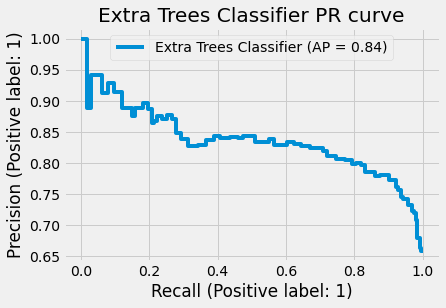

In [96]:
et_baseline = ExtraTreesClassifier()
et_baseline.fit(X_train, y_train)

train_auc = et_baseline.score(X_train, y_train)
test_auc = et_baseline.score(X_test, y_test)
print(f'Extra Tree train accuracy: {train_auc}')
print(f'Extra Tree Test accuracy: {test_auc}') 

et_precision, et_recall, _ = precision_recall_curve(y_test, et_baseline.predict_proba(X_test)[:,1])
print(auc(et_recall, et_precision))

plot_precision_recall_curve(et_baseline, X_test, y_test, name = 'Extra Trees Classifier')
plt.legend(loc="upper center");
plt.title('Extra Trees Classifier PR curve');

### XGBoost Baseline

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:23:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614844528294/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8553956630006916
XGBoost train accuracy: 1.0
XGBoost Test accuracy: 0.7980769230769231


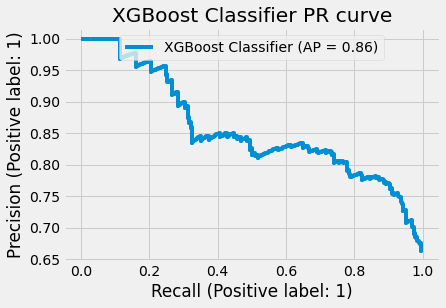

In [97]:
xgb_baseline = XGBClassifier()
xgb_baseline.fit(X_train, y_train)

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_baseline.predict_proba(X_test)[:,1])
print(auc(xgb_recall, xgb_precision))

train_auc = xgb_baseline.score(X_train, y_train)
test_auc = xgb_baseline.score(X_test, y_test)
print(f'XGBoost train accuracy: {train_auc}')
print(f'XGBoost Test accuracy: {test_auc}') 

plot_precision_recall_curve(xgb_baseline, X_test, y_test, name = 'XGBoost Classifier')
plt.legend(loc="upper center");
plt.title('XGBoost Classifier PR curve');

### Baseline Models Summary:

|Model | PR AUC SCORE | Train accuracy | Test Accuracy | 
|------|--------------|----------------|---------------|
|Random Forest | 0.84 | 1.0 | 0.75 |
|Decision Tree |0.81 | 1.0 | 0.75 |
|Extra Tree Classifier |0.83| 1.0 |0.80|
|XGBoost |0.85|1.0| 0.79|

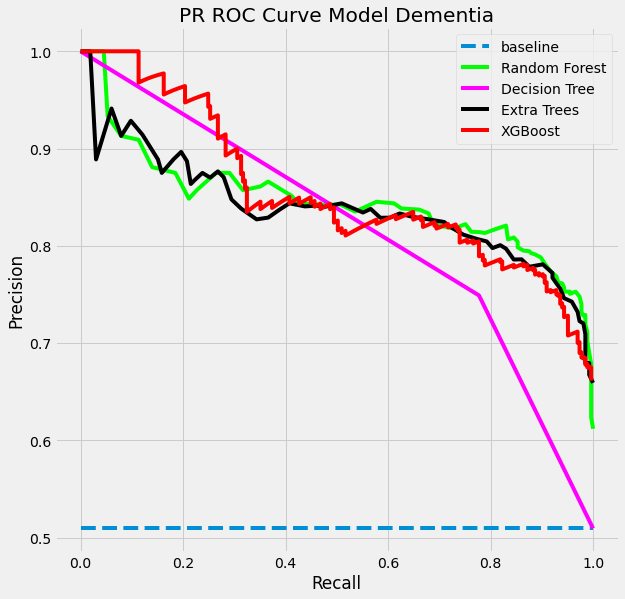

In [142]:
pyplot.figure(figsize=(9,9))
# calculate the no skill line as the proportion of the positive class
baseline = len(y_test[y_test==1]) / len(y_test)
#plot the no skill precision-recall curve
pyplot.plot([0, 1], [baseline, baseline], linestyle='--', label='baseline')
# plot model precision-recall curve
pyplot.plot(rf_recall ,rf_precision,label='Random Forest',color='lime')
pyplot.plot(dt_recall ,dt_precision,label='Decision Tree', color='magenta')
pyplot.plot(et_recall ,et_precision,label='Extra Trees', color='black')
pyplot.plot(xgb_recall ,xgb_precision,label='XGBoost', color='red')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.title("PR ROC Curve Model Dementia")
pyplot.show()

The comparision across baseline models performance evaluated by PR ROC curve shows very similar performance. The Decision tree model shows a higher potential for both percision and recall while the RandomForest classifier show a potential for higher recal than other models and XGboost curve goes the hiestest in percision.

<a name="4"></a>
# Best Model Gridsearch

In the preivous Notebook the classifier model that had proved to be the most robust in terms of roc auc was the XGBoost. Below the data will be fitted to the XGBoost model with the hyperparameters that peformed the best in terms of ROC AUC and evaluated further for feature importance and percision. 

### Gridsearch

Below a gridsearch across XGBoost is being created. First specifying the constant parameters of the classifier. The objective- in this case, is “binary:logistic” function because the classifier is being trained to handle only two classes:
- **class 1** 1 (dementia)<br>
- **class 2** 0 (No Dementia)<br>
<br>
Additionally, the number of threads is being specified to speed up the training. The random seed set to 42 will assure the same results each time the gridsearch is ran. The parameters used a range of values for the gridsearch to fit a the classifyer too. 

In [103]:
#defining Estimators
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

#defining Parameters
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

#Creating Gridserch with 10 cross validaiton
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'average_precision',
    n_jobs = 10,
    cv = 10,
    verbose=True
)



In [104]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:37:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614844528294/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=No

In [105]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [106]:
grid_search.best_score_

0.8650321419443154

# Best Model

In [116]:
xgb_final = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [117]:
xgb_final.fit(X_train,y_train)

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:44:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614844528294/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Training auccuracy: 0.854080791426216
Test auccuracy: 0.8192307692307692

Order of classes:  [0 1]

Test Confusion Matrix: 
           predicted 0  predicted 1
actual 0          194           61
actual 1           33          232

True Negatives: 194
False Positives: 61
False Negatives: 33
True Positives: 232
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       255
           1       0.79      0.88      0.83       265

    accuracy                           0.82       520
   macro avg       0.82      0.82      0.82       520
weighted avg       0.82      0.82      0.82       520



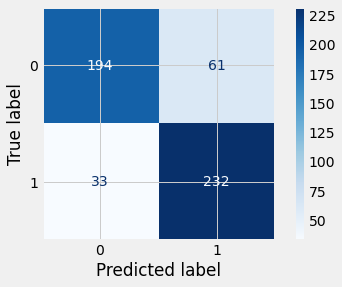

In [118]:
#plotting evaluation metrix and confusion matrix
evaluation(xgb_final, X_train, y_train, X_test, y_test)

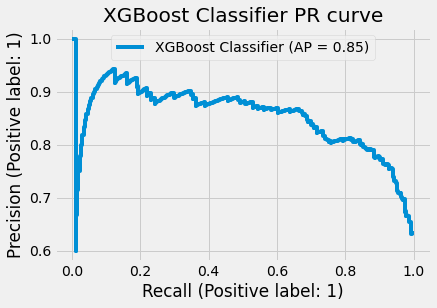

In [120]:
plot_precision_recall_curve(xgb_final, X_test, y_test, name = 'XGBoost Classifier')
plt.legend(loc="upper center");
plt.title('XGBoost Classifier PR curve');

### Interpretation:

Overall performance of the predictive model is measured using the percision recall area under the receiver operating characteristics curve (PR AUC SCORE) and confusion matrix measuring sensitivity, specificity, PPV, and accuracy


In [144]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': xgb_final.predict_proba(X_test)[:,1]})

pred_df.head()

,true_values,pred_probs
29,0,0.012967
1409,1,0.605708
1610,1,0.723593
539,0,0.007478
1620,1,0.805759


/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


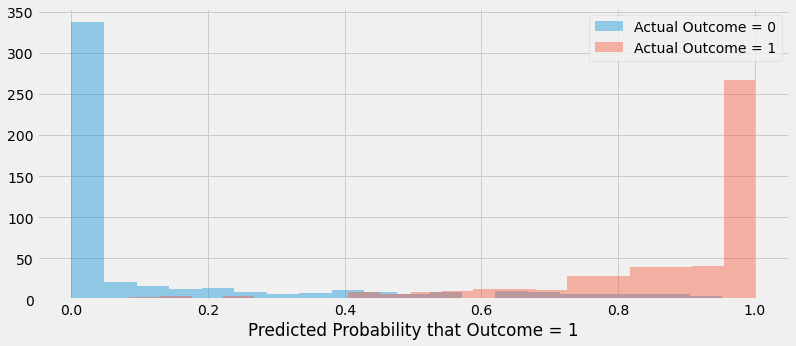

In [145]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

In [122]:
features_xgb=pd.DataFrame()
features_xgb['columns']=X.columns
features_xgb['importances'] = xgb_final.feature_importances_
features_xgb.sort_values(by='importances',ascending=False,inplace=True)

<a name="5"></a>
# Feature Evaluation

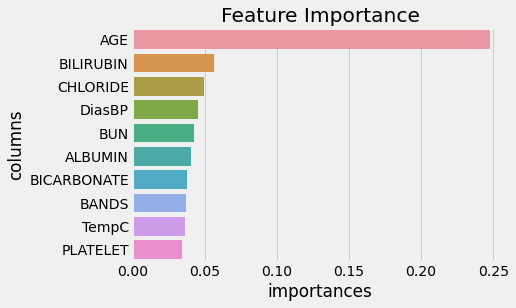

In [143]:
features_xgb= features_xgb.head(10)
sns.barplot(data=features_xgb, y='columns', x='importances');
plt.title('Feature Importance');

## Feature Importance
The model performance indicated that top 5 important features are:<br>
    1) Age <br>
    2) Bilirubin lab test <br>
    3) Chloride <br>
    4) Diastolic Blood Pressure <br>
    5) BUN <br>

The Model feature importance measurement is set to **gain** this is measuring the improvement in accuracy brought by a feature to the branches it is on. The idea is that before adding a new split on a feature X to the branch there was some wrongly classified elements. After adding the split on this feature, there are two new branches, and each of these branch is more accurate.

The gain for AGE is 0.24 indicating that is the top most important feature within the dataset at identifying the dementia patients. This is not surprising due to the dementia patients typically being in a older class demographic. 


The next most important feature measured by grain is the BILRUBIN lab test. after outside research there are several research studies that show BILRUBIN is significantly higher in dementia patients with dementia and types of dementia such as lewybody [source](#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7494757/). 



# Conclusion

The hypertuned XGBoost final model is most likely not the best model out there. Although a high number of models were created, it is clear that the described approach has not found the very best model performance. To obtain better results, one could alter the search space or even include more hyperparameters. Still, finding the perfect model could not be stated after additional random searches with changed settings.

In terms of the implications from the final model performance it still tells a story of difficulty in differentiating patients diagnosed with dementia to those who have not been diagnosed with dementia from our dataset features. Possible solutions to improve this could be finding a dataset that offers a larger sample of the positive class with features of brain scans, physical evaluations and other test used by doctors for diagnosis. 

The models most important features give light to possible indications to look out for in lab test for patients at risk for developing dementia. In the next notebook I will execute a 2nd approach to anlyzing this problem. 